In [1]:
import csv
import cv2
import sklearn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout, Activation, Cropping2D
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras import optimizers
from keras.models import load_model
from keras.models import Model

Using TensorFlow backend.


In [3]:
model_file = 'model.h5'
model_weights_file = 'model-weights.h5'
data_folder = 'data/'

In [4]:
# Each sample is a line from the .csv file

samples = []
with open (data_folder+'driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for sample in reader:
        samples.append(sample)

sklearn.utils.shuffle(samples)
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)
print(len(samples))

14006


In [5]:
# Generator for training

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name = data_folder+'/IMG/'+batch_sample[0].split('\\')[-1]
                center_image = cv2.imread(name)
                
                # Swap BGR to RGB
                center_image = center_image[:,:,::-1]
                center_angle = float(batch_sample[3])
                images.append(center_image)
                angles.append(center_angle)
                
                # Flip horizontal
                horizontal_flip = cv2.flip( center_image, 0 )
                images.append(horizontal_flip)
                angles.append(-center_angle)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)
        
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=16) # 7 min
train_generator = generator(train_samples, batch_size=8) # 4 min
validation_generator = generator(validation_samples, batch_size=16)

In [7]:
# Define the model

model = Sequential()

# Crop 35 pixels from top, ad 15 pixels from bottom
model.add(Cropping2D(cropping=((35,15), (0,0)), input_shape=(160,320,3)))

#model.add(Lambda(lambda x : x / 255.0 -0.5, input_shape=(160,320,3)))
model.add(Lambda(lambda x : x / 255.0 -0.5))

# Conv layer 1: kernel = (5,5), stride = (2,2); out_depth = 24; 
model.add(Conv2D(24, kernel_size=5, activation='relu', strides=(2, 2), padding='valid'))

# Conv layer 2: kernel = (5,5), stride = (2,2); out_depth = 24; 
model.add(Conv2D(36, kernel_size=5,  strides=(2, 2), activation='relu', padding='valid'))

# Conv layer 3: kernel = (3,3), stride = (1,1); out_depth = 64; 
model.add(Conv2D(64, kernel_size=3, activation='relu', padding='valid'))

# Conv layer 3: kernel = (3,3), stride = (1,1); out_depth = 64; 
model.add(Conv2D(64, kernel_size=3, activation='relu', padding='valid'))

# Dropout layer
model.add(Dropout(0.35, noise_shape=None, seed=None))

#1st FCN Layer - Add a flatten layer
model.add(Flatten())

#2nd Layer - Add a fully connected layer
model.add(Dense(100))

#3rd Layer - Add a ReLU activation layer
model.add(Dense(50))

model.add(Dense(1))

In [8]:
# Load the weights to continue training from where last stopped
#model.load_weights(model_weights_file)

epochs_train = 4

# Train
ada = optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
sgd = optimizers.SGD(lr=0.003, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mse', optimizer=ada)

history_object = model.fit_generator(train_generator, steps_per_epoch= len(train_samples), validation_data=validation_generator, validation_steps=len(validation_samples), epochs=epochs_train, verbose = 1)

Epoch 1/4
11204/11204 [==============================] - 511s 46ms/step - loss: 0.0206 - val_loss: 0.0229
Epoch 2/4
11204/11204 [==============================] - 494s 44ms/step - loss: 0.0063 - val_loss: 0.0184
Epoch 3/4
11204/11204 [==============================] - 496s 44ms/step - loss: 0.0042 - val_loss: 0.0178
Epoch 4/4
11204/11204 [==============================] - 491s 44ms/step - loss: 0.0035 - val_loss: 0.0175


In [9]:
# Save the model and the weights
model.save(model_file)
model.save_weights(model_weights_file)

dict_keys(['val_loss', 'loss'])


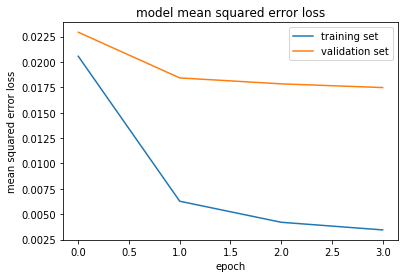

In [10]:
# Visualizing the loss

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()


In [13]:
# Reset all weights
from keras.initializers import glorot_uniform  # Or your initializer of choice
import tensorflow as tf
sess = tf.Session();
initial_weights = model.get_weights()
new_weights = [glorot_uniform()(w.shape).eval(session = sess) for w in initial_weights]

In [14]:
# RUN THIS TO RESET
model.set_weights(new_weights)